# Prepare a tfdataset object on the full data

This notebook runs on MSI

### Install external packages

## Load Python packages

In [2]:
#import tensorflow as tf
import numpy as np
#from tensorflow import keras
#from tensorflow.keras import layers
#import tensorflow_addons as tfa
from scipy import stats
import session_info
#import tensorflow_probability as tfp
import pdb
from sklearn.metrics import r2_score
import shutil
import pandas as pd
import re
import os
from Bio.Seq import Seq
import gc
import matplotlib.pyplot as plt
import datetime


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
import math
import pickle as pk

## Parameters

In [4]:
ARGS = {
  'max_width' : 100,
  'pct_ds' : 1, # % of total data for training/testing
  'alphabets' : {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3, 'N' : 4, 'M' : 5},
  'missing_letter' : 'N',
  'mask_letter' : 'M',
  'max_expression_value' : 17,
  'head_len' : 17,
  'tail_len' : 13,
}
ARGS['remote_data_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
ARGS['local_data_dir'] = re.sub('https://', './', ARGS['remote_data_dir'])

In [5]:
print(ARGS['remote_data_dir'])
print(ARGS['local_data_dir'])

https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=1/
./s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=1/


## Prepare data

In [6]:
remote_train_file ='https://s3.msi.umn.edu/gongx030/projects/dream_PGE/train_sequences.txt.gz'
local_train_file = re.sub('https://', './', remote_train_file)
os.system('wget -cx ' + remote_train_file)

--2023-03-03 07:19:01--  https://s3.msi.umn.edu/gongx030/projects/dream_PGE/train_sequences.txt.gz
Resolving s3.msi.umn.edu (s3.msi.umn.edu)... 128.101.189.144
Connecting to s3.msi.umn.edu (s3.msi.umn.edu)|128.101.189.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223629919 (213M) [application/x-gzip]
Saving to: ‘s3.msi.umn.edu/gongx030/projects/dream_PGE/train_sequences.txt.gz’

     0K .......... .......... .......... .......... ..........  0%  151K 24m6s
    50K .......... .......... .......... .......... ..........  0%  157K 23m39s
   100K .......... .......... .......... .......... ..........  0% 96.7M 15m46s
   150K .......... .......... .......... .......... ..........  0%  309K 14m46s
   200K .......... .......... .......... .......... ..........  0%  323K 14m4s
   250K .......... .......... .......... .......... ..........  0%  318K 13m37s
   300K .......... .......... .......... .......... ..........  0%  316K 13m19s
   350K .......... .........

  4850K .......... .......... .......... .......... ..........  2%  107K 25m53s
  4900K .......... .......... .......... .......... ..........  2% 93.6K 26m0s
  4950K .......... .......... .......... .......... ..........  2% 21.5K 27m23s
  5000K .......... .......... .......... .......... ..........  2% 18.2K 29m3s
  5050K .......... .......... .......... .......... ..........  2% 63.8K 29m18s
  5100K .......... .......... .......... .......... ..........  2% 79.7K 29m27s
  5150K .......... .......... .......... .......... ..........  2% 78.3K 29m35s
  5200K .......... .......... .......... .......... ..........  2% 79.6K 29m44s
  5250K .......... .......... .......... .......... ..........  2%  162K 29m39s
  5300K .......... .......... .......... .......... ..........  2%  212K 29m31s
  5350K .......... .......... .......... .......... ..........  2%  256K 29m22s
  5400K .......... .......... .......... .......... ..........  2%  247K 29m13s
  5450K .......... .......... .......... .

 10000K .......... .......... .......... .......... ..........  4%  197K 26m26s
 10050K .......... .......... .......... .......... ..........  4%  620K 26m19s
 10100K .......... .......... .......... .......... ..........  4%  211K 26m16s
 10150K .......... .......... .......... .......... ..........  4%  266K 26m11s
 10200K .......... .......... .......... .......... ..........  4%  167K 26m9s
 10250K .......... .......... .......... .......... ..........  4%  105K 26m11s
 10300K .......... .......... .......... .......... ..........  4%  104K 26m13s
 10350K .......... .......... .......... .......... ..........  4% 96.4K 26m15s
 10400K .......... .......... .......... .......... ..........  4% 83.3K 26m19s
 10450K .......... .......... .......... .......... ..........  4%  205K 26m16s
 10500K .......... .......... .......... .......... ..........  4%  203K 26m13s
 10550K .......... .......... .......... .......... ..........  4%  301K 26m9s
 10600K .......... .......... .......... .

 15200K .......... .......... .......... .......... ..........  6%  126K 27m12s
 15250K .......... .......... .......... .......... ..........  7%  173K 27m10s
 15300K .......... .......... .......... .......... ..........  7%  244K 27m7s
 15350K .......... .......... .......... .......... ..........  7%  189K 27m5s
 15400K .......... .......... .......... .......... ..........  7%  243K 27m2s
 15450K .......... .......... .......... .......... ..........  7%  182K 27m0s
 15500K .......... .......... .......... .......... ..........  7%  323K 26m56s
 15550K .......... .......... .......... .......... ..........  7%  242K 26m53s
 15600K .......... .......... .......... .......... ..........  7%  168K 26m51s
 15650K .......... .......... .......... .......... ..........  7%  199K 26m49s
 15700K .......... .......... .......... .......... ..........  7%  271K 26m46s
 15750K .......... .......... .......... .......... ..........  7%  162K 26m45s
 15800K .......... .......... .......... ...

 20350K .......... .......... .......... .......... ..........  9%  256K 23m44s
 20400K .......... .......... .......... .......... ..........  9%  196K 23m43s
 20450K .......... .......... .......... .......... ..........  9%  306K 23m40s
 20500K .......... .......... .......... .......... ..........  9%  330K 23m38s
 20550K .......... .......... .......... .......... ..........  9%  469K 23m35s
 20600K .......... .......... .......... .......... ..........  9%  557K 23m32s
 20650K .......... .......... .......... .......... ..........  9%  411K 23m30s
 20700K .......... .......... .......... .......... ..........  9%  594K 23m27s
 20750K .......... .......... .......... .......... ..........  9%  634K 23m24s
 20800K .......... .......... .......... .......... ..........  9%  523K 23m21s
 20850K .......... .......... .......... .......... ..........  9%  631K 23m18s
 20900K .......... .......... .......... .......... ..........  9%  696K 23m15s
 20950K .......... .......... ..........

 25550K .......... .......... .......... .......... .......... 11%  178K 21m12s
 25600K .......... .......... .......... .......... .......... 11%  148K 21m11s
 25650K .......... .......... .......... .......... .......... 11%  222K 21m10s
 25700K .......... .......... .......... .......... .......... 11%  207K 21m9s
 25750K .......... .......... .......... .......... .......... 11%  208K 21m8s
 25800K .......... .......... .......... .......... .......... 11%  172K 21m8s
 25850K .......... .......... .......... .......... .......... 11%  146K 21m7s
 25900K .......... .......... .......... .......... .......... 11%  162K 21m7s
 25950K .......... .......... .......... .......... .......... 11%  144K 21m7s
 26000K .......... .......... .......... .......... .......... 11% 85.4K 21m8s
 26050K .......... .......... .......... .......... .......... 11% 59.7K 21m12s
 26100K .......... .......... .......... .......... .......... 11% 97.2K 21m13s
 26150K .......... .......... .......... ......

 30750K .......... .......... .......... .......... .......... 14%  277K 20m17s
 30800K .......... .......... .......... .......... .......... 14%  176K 20m17s
 30850K .......... .......... .......... .......... .......... 14%  209K 20m16s
 30900K .......... .......... .......... .......... .......... 14%  236K 20m15s
 30950K .......... .......... .......... .......... .......... 14%  265K 20m14s
 31000K .......... .......... .......... .......... .......... 14%  235K 20m13s
 31050K .......... .......... .......... .......... .......... 14%  321K 20m11s
 31100K .......... .......... .......... .......... .......... 14%  294K 20m10s
 31150K .......... .......... .......... .......... .......... 14%  363K 20m9s
 31200K .......... .......... .......... .......... .......... 14%  302K 20m7s
 31250K .......... .......... .......... .......... .......... 14%  434K 20m6s
 31300K .......... .......... .......... .......... .......... 14%  457K 20m4s
 31350K .......... .......... .......... ...

 35950K .......... .......... .......... .......... .......... 16%  839K 18m33s
 36000K .......... .......... .......... .......... .......... 16%  198K 18m32s
 36050K .......... .......... .......... .......... .......... 16%  294K 18m31s
 36100K .......... .......... .......... .......... .......... 16%  270K 18m30s
 36150K .......... .......... .......... .......... .......... 16%  323K 18m29s
 36200K .......... .......... .......... .......... .......... 16%  295K 18m28s
 36250K .......... .......... .......... .......... .......... 16%  295K 18m27s
 36300K .......... .......... .......... .......... .......... 16%  296K 18m26s
 36350K .......... .......... .......... .......... .......... 16%  405K 18m25s
 36400K .......... .......... .......... .......... .......... 16%  266K 18m24s
 36450K .......... .......... .......... .......... .......... 16%  434K 18m23s
 36500K .......... .......... .......... .......... .......... 16%  221K 18m22s
 36550K .......... .......... ..........

 41100K .......... .......... .......... .......... .......... 18%  148K 17m30s
 41150K .......... .......... .......... .......... .......... 18% 86.0K 17m31s
 41200K .......... .......... .......... .......... .......... 18% 58.2K 17m33s
 41250K .......... .......... .......... .......... .......... 18% 64.1K 17m35s
 41300K .......... .......... .......... .......... .......... 18% 80.0K 17m36s
 41350K .......... .......... .......... .......... .......... 18%  136K 17m36s
 41400K .......... .......... .......... .......... .......... 18%  195K 17m36s
 41450K .......... .......... .......... .......... .......... 19%  246K 17m35s
 41500K .......... .......... .......... .......... .......... 19%  162K 17m35s
 41550K .......... .......... .......... .......... .......... 19%  154K 17m34s
 41600K .......... .......... .......... .......... .......... 19%  132K 17m34s
 41650K .......... .......... .......... .......... .......... 19%  208K 17m34s
 41700K .......... .......... ..........

 46200K .......... .......... .......... .......... .......... 21% 96.9K 17m25s
 46250K .......... .......... .......... .......... .......... 21% 95.8K 17m25s
 46300K .......... .......... .......... .......... .......... 21% 56.7K 17m27s
 46350K .......... .......... .......... .......... .......... 21% 79.3K 17m28s
 46400K .......... .......... .......... .......... .......... 21%  101K 17m28s
 46450K .......... .......... .......... .......... .......... 21%  116K 17m28s
 46500K .......... .......... .......... .......... .......... 21%  340K 17m28s
 46550K .......... .......... .......... .......... .......... 21%  201K 17m27s
 46600K .......... .......... .......... .......... .......... 21%  109K 17m27s
 46650K .......... .......... .......... .......... .......... 21%  144K 17m27s
 46700K .......... .......... .......... .......... .......... 21%  108K 17m27s
 46750K .......... .......... .......... .......... .......... 21%  146K 17m27s
 46800K .......... .......... ..........

 51350K .......... .......... .......... .......... .......... 23%  154K 17m14s
 51400K .......... .......... .......... .......... .......... 23%  176K 17m14s
 51450K .......... .......... .......... .......... .......... 23%  163K 17m14s
 51500K .......... .......... .......... .......... .......... 23%  160K 17m13s
 51550K .......... .......... .......... .......... .......... 23%  142K 17m13s
 51600K .......... .......... .......... .......... .......... 23%  108K 17m13s
 51650K .......... .......... .......... .......... .......... 23%  125K 17m13s
 51700K .......... .......... .......... .......... .......... 23% 89.3K 17m14s
 51750K .......... .......... .......... .......... .......... 23% 91.1K 17m14s
 51800K .......... .......... .......... .......... .......... 23%  108K 17m15s
 51850K .......... .......... .......... .......... .......... 23%  115K 17m15s
 51900K .......... .......... .......... .......... .......... 23%  217K 17m14s
 51950K .......... .......... ..........

 56450K .......... .......... .......... .......... .......... 25%  325K 17m46s
 56500K .......... .......... .......... .......... .......... 25%  325K 17m45s
 56550K .......... .......... .......... .......... .......... 25%  325K 17m45s
 56600K .......... .......... .......... .......... .......... 25%  843K 17m43s
 56650K .......... .......... .......... .......... .......... 25%  322K 17m43s
 56700K .......... .......... .......... .......... .......... 25%  361K 17m42s
 56750K .......... .......... .......... .......... .......... 26%  348K 17m41s
 56800K .......... .......... .......... .......... .......... 26%  306K 17m40s
 56850K .......... .......... .......... .......... .......... 26%  385K 17m39s
 56900K .......... .......... .......... .......... .......... 26%  842K 17m38s
 56950K .......... .......... .......... .......... .......... 26%  439K 17m37s
 57000K .......... .......... .......... .......... .......... 26%  251K 17m36s
 57050K .......... .......... ..........

 61600K .......... .......... .......... .......... .......... 28%  148K 16m38s
 61650K .......... .......... .......... .......... .......... 28% 98.4K 16m38s
 61700K .......... .......... .......... .......... .......... 28% 67.5K 16m39s
 61750K .......... .......... .......... .......... .......... 28% 64.8K 16m40s
 61800K .......... .......... .......... .......... .......... 28% 83.8K 16m40s
 61850K .......... .......... .......... .......... .......... 28%  150K 16m40s
 61900K .......... .......... .......... .......... .......... 28%  269K 16m39s
 61950K .......... .......... .......... .......... .......... 28%  190K 16m39s
 62000K .......... .......... .......... .......... .......... 28%  292K 16m38s
 62050K .......... .......... .......... .......... .......... 28%  160K 16m38s
 62100K .......... .......... .......... .......... .......... 28%  213K 16m37s
 62150K .......... .......... .......... .......... .......... 28%  203K 16m37s
 62200K .......... .......... ..........

 66700K .......... .......... .......... .......... .......... 30%  243K 16m25s
 66750K .......... .......... .......... .......... .......... 30%  253K 16m24s
 66800K .......... .......... .......... .......... .......... 30%  198K 16m24s
 66850K .......... .......... .......... .......... .......... 30%  297K 16m23s
 66900K .......... .......... .......... .......... .......... 30%  472K 16m22s
 66950K .......... .......... .......... .......... .......... 30%  328K 16m21s
 67000K .......... .......... .......... .......... .......... 30%  586K 16m20s
 67050K .......... .......... .......... .......... .......... 30%  416K 16m20s
 67100K .......... .......... .......... .......... .......... 30%  497K 16m19s
 67150K .......... .......... .......... .......... .......... 30%  304K 16m18s
 67200K .......... .......... .......... .......... .......... 30%  288K 16m18s
 67250K .......... .......... .......... .......... .......... 30%  245K 16m17s
 67300K .......... .......... ..........

 71950K .......... .......... .......... .......... .......... 32%  573K 16m13s
 72000K .......... .......... .......... .......... .......... 32%  818K 16m12s
 72050K .......... .......... .......... .......... .......... 33%  554K 16m11s
 72100K .......... .......... .......... .......... .......... 33% 1.05M 16m11s
 72150K .......... .......... .......... .......... .......... 33%  507K 16m10s
 72200K .......... .......... .......... .......... .......... 33%  964K 16m9s
 72250K .......... .......... .......... .......... .......... 33%  675K 16m8s
 72300K .......... .......... .......... .......... .......... 33%  637K 16m7s
 72350K .......... .......... .......... .......... .......... 33%  236K 16m7s
 72400K .......... .......... .......... .......... .......... 33%  129M 16m6s
 72450K .......... .......... .......... .......... .......... 33% 1.70M 16m5s
 72500K .......... .......... .......... .......... .......... 33%  338K 16m4s
 72550K .......... .......... .......... ......

 77200K .......... .......... .......... .......... .......... 35% 1.20M 15m10s
 77250K .......... .......... .......... .......... .......... 35% 1.15M 15m9s
 77300K .......... .......... .......... .......... .......... 35%  795K 15m8s
 77350K .......... .......... .......... .......... .......... 35% 2.34M 15m7s
 77400K .......... .......... .......... .......... .......... 35% 1.37M 15m7s
 77450K .......... .......... .......... .......... .......... 35% 1.43M 15m6s
 77500K .......... .......... .......... .......... .......... 35%  844K 15m5s
 77550K .......... .......... .......... .......... .......... 35% 1.75M 15m4s
 77600K .......... .......... .......... .......... .......... 35% 1.23M 15m3s
 77650K .......... .......... .......... .......... .......... 35% 1.51M 15m2s
 77700K .......... .......... .......... .......... .......... 35%  963K 15m2s
 77750K .......... .......... .......... .......... .......... 35% 2.09M 15m1s
 77800K .......... .......... .......... ..........

 82350K .......... .......... .......... .......... .......... 37%  284K 13m59s
 82400K .......... .......... .......... .......... .......... 37%  252K 13m59s
 82450K .......... .......... .......... .......... .......... 37%  354K 13m58s
 82500K .......... .......... .......... .......... .......... 37%  455K 13m57s
 82550K .......... .......... .......... .......... .......... 37%  502K 13m57s
 82600K .......... .......... .......... .......... .......... 37%  495K 13m56s
 82650K .......... .......... .......... .......... .......... 37%  585K 13m55s
 82700K .......... .......... .......... .......... .......... 37%  492K 13m55s
 82750K .......... .......... .......... .......... .......... 37%  604K 13m54s
 82800K .......... .......... .......... .......... .......... 37%  570K 13m53s
 82850K .......... .......... .......... .......... .......... 37%  743K 13m53s
 82900K .......... .......... .......... .......... .......... 37%  743K 13m52s
 82950K .......... .......... ..........

 87450K .......... .......... .......... .......... .......... 40%  314K 12m49s
 87500K .......... .......... .......... .......... .......... 40%  433K 12m49s
 87550K .......... .......... .......... .......... .......... 40%  382K 12m48s
 87600K .......... .......... .......... .......... .......... 40%  331K 12m48s
 87650K .......... .......... .......... .......... .......... 40%  549K 12m47s
 87700K .......... .......... .......... .......... .......... 40%  423K 12m46s
 87750K .......... .......... .......... .......... .......... 40%  827K 12m46s
 87800K .......... .......... .......... .......... .......... 40%  463K 12m45s
 87850K .......... .......... .......... .......... .......... 40%  882K 12m45s
 87900K .......... .......... .......... .......... .......... 40%  509K 12m44s
 87950K .......... .......... .......... .......... .......... 40%  859K 12m43s
 88000K .......... .......... .......... .......... .......... 40%  466K 12m43s
 88050K .......... .......... ..........

 92700K .......... .......... .......... .......... .......... 42%  745K 11m43s
 92750K .......... .......... .......... .......... .......... 42%  981K 11m42s
 92800K .......... .......... .......... .......... .......... 42%  713K 11m42s
 92850K .......... .......... .......... .......... .......... 42%  666K 11m41s
 92900K .......... .......... .......... .......... .......... 42% 1010K 11m41s
 92950K .......... .......... .......... .......... .......... 42%  767K 11m40s
 93000K .......... .......... .......... .......... .......... 42%  935K 11m40s
 93050K .......... .......... .......... .......... .......... 42%  919K 11m39s
 93100K .......... .......... .......... .......... .......... 42%  707K 11m38s
 93150K .......... .......... .......... .......... .......... 42% 1007K 11m38s
 93200K .......... .......... .......... .......... .......... 42%  668K 11m37s
 93250K .......... .......... .......... .......... .......... 42%  713K 11m37s
 93300K .......... .......... ..........

 98100K .......... .......... .......... .......... .......... 44% 2.30M 10m43s
 98150K .......... .......... .......... .......... .......... 44% 4.07M 10m42s
 98200K .......... .......... .......... .......... .......... 44% 4.70M 10m41s
 98250K .......... .......... .......... .......... .......... 45% 4.78M 10m41s
 98300K .......... .......... .......... .......... .......... 45% 3.26M 10m40s
 98350K .......... .......... .......... .......... .......... 45%  863K 10m40s
 98400K .......... .......... .......... .......... .......... 45% 1.92M 10m39s
 98450K .......... .......... .......... .......... .......... 45% 2.42M 10m39s
 98500K .......... .......... .......... .......... .......... 45% 3.16M 10m38s
 98550K .......... .......... .......... .......... .......... 45% 4.15M 10m37s
 98600K .......... .......... .......... .......... .......... 45% 4.80M 10m37s
 98650K .......... .......... .......... .......... .......... 45% 4.12M 10m36s
 98700K .......... .......... ..........

103350K .......... .......... .......... .......... .......... 47%  982K 9m49s
103400K .......... .......... .......... .......... .......... 47%  958K 9m48s
103450K .......... .......... .......... .......... .......... 47% 2.18M 9m48s
103500K .......... .......... .......... .......... .......... 47% 2.25M 9m47s
103550K .......... .......... .......... .......... .......... 47% 1.14M 9m47s
103600K .......... .......... .......... .......... .......... 47%  677K 9m46s
103650K .......... .......... .......... .......... .......... 47% 2.09M 9m46s
103700K .......... .......... .......... .......... .......... 47% 3.33M 9m45s
103750K .......... .......... .......... .......... .......... 47% 1.75M 9m45s
103800K .......... .......... .......... .......... .......... 47%  734K 9m44s
103850K .......... .......... .......... .......... .......... 47% 1.48M 9m44s
103900K .......... .......... .......... .......... .......... 47% 2.51M 9m43s
103950K .......... .......... .......... .......... 

108800K .......... .......... .......... .......... .......... 49% 1.24M 9m6s
108850K .......... .......... .......... .......... .......... 49% 2.20M 9m6s
108900K .......... .......... .......... .......... .......... 49% 1.31M 9m5s
108950K .......... .......... .......... .......... .......... 49% 1.31M 9m5s
109000K .......... .......... .......... .......... .......... 49% 3.03M 9m4s
109050K .......... .......... .......... .......... .......... 49% 1.99M 9m4s
109100K .......... .......... .......... .......... .......... 49% 1.50M 9m3s
109150K .......... .......... .......... .......... .......... 50% 2.79M 9m3s
109200K .......... .......... .......... .......... .......... 50%  961K 9m2s
109250K .......... .......... .......... .......... .......... 50% 2.48M 9m2s
109300K .......... .......... .......... .......... .......... 50% 4.34M 9m1s
109350K .......... .......... .......... .......... .......... 50% 2.10M 9m1s
109400K .......... .......... .......... .......... .......... 5

114150K .......... .......... .......... .......... .......... 52%  928K 8m18s
114200K .......... .......... .......... .......... .......... 52% 1.15M 8m18s
114250K .......... .......... .......... .......... .......... 52%  852K 8m18s
114300K .......... .......... .......... .......... .......... 52% 1.18M 8m17s
114350K .......... .......... .......... .......... .......... 52% 1.15M 8m17s
114400K .......... .......... .......... .......... .......... 52%  311K 8m16s
114450K .......... .......... .......... .......... .......... 52%  471K 8m16s
114500K .......... .......... .......... .......... .......... 52%  140M 8m16s
114550K .......... .......... .......... .......... .......... 52%  151M 8m15s
114600K .......... .......... .......... .......... .......... 52% 1.88M 8m15s
114650K .......... .......... .......... .......... .......... 52%  872K 8m14s
114700K .......... .......... .......... .......... .......... 52%  512K 8m14s
114750K .......... .......... .......... .......... 

119450K .......... .......... .......... .......... .......... 54%  795K 7m41s
119500K .......... .......... .......... .......... .......... 54% 1.23M 7m41s
119550K .......... .......... .......... .......... .......... 54%  706K 7m40s
119600K .......... .......... .......... .......... .......... 54%  691K 7m40s
119650K .......... .......... .......... .......... .......... 54%  700K 7m40s
119700K .......... .......... .......... .......... .......... 54%  817K 7m39s
119750K .......... .......... .......... .......... .......... 54% 1.18M 7m39s
119800K .......... .......... .......... .......... .......... 54%  662K 7m38s
119850K .......... .......... .......... .......... .......... 54%  884K 7m38s
119900K .......... .......... .......... .......... .......... 54% 1.22M 7m38s
119950K .......... .......... .......... .......... .......... 54%  607K 7m37s
120000K .......... .......... .......... .......... .......... 54%  840K 7m37s
120050K .......... .......... .......... .......... 

124700K .......... .......... .......... .......... .......... 57%  347K 7m5s
124750K .......... .......... .......... .......... .......... 57%  219K 7m5s
124800K .......... .......... .......... .......... .......... 57%  302K 7m5s
124850K .......... .......... .......... .......... .......... 57%  248K 7m5s
124900K .......... .......... .......... .......... .......... 57%  233K 7m4s
124950K .......... .......... .......... .......... .......... 57%  229K 7m4s
125000K .......... .......... .......... .......... .......... 57%  247K 7m4s
125050K .......... .......... .......... .......... .......... 57%  229K 7m4s
125100K .......... .......... .......... .......... .......... 57%  276K 7m3s
125150K .......... .......... .......... .......... .......... 57%  249K 7m3s
125200K .......... .......... .......... .......... .......... 57%  254K 7m3s
125250K .......... .......... .......... .......... .......... 57%  236K 7m3s
125300K .......... .......... .......... .......... .......... 5

130000K .......... .......... .......... .......... .......... 59%  936K 6m32s
130050K .......... .......... .......... .......... .......... 59%  802K 6m32s
130100K .......... .......... .......... .......... .......... 59% 1.43M 6m32s
130150K .......... .......... .......... .......... .......... 59% 1.72M 6m31s
130200K .......... .......... .......... .......... .......... 59%  860K 6m31s
130250K .......... .......... .......... .......... .......... 59% 1.15M 6m31s
130300K .......... .......... .......... .......... .......... 59% 1.54M 6m30s
130350K .......... .......... .......... .......... .......... 59% 2.22M 6m30s
130400K .......... .......... .......... .......... .......... 59%  787K 6m30s
130450K .......... .......... .......... .......... .......... 59% 1.20M 6m29s
130500K .......... .......... .......... .......... .......... 59% 1.85M 6m29s
130550K .......... .......... .......... .......... .......... 59% 2.01M 6m29s
130600K .......... .......... .......... .......... 

135400K .......... .......... .......... .......... .......... 62% 2.48M 5m59s
135450K .......... .......... .......... .......... .......... 62% 1.59M 5m58s
135500K .......... .......... .......... .......... .......... 62% 2.86M 5m58s
135550K .......... .......... .......... .......... .......... 62%  953K 5m58s
135600K .......... .......... .......... .......... .......... 62%  309K 5m58s
135650K .......... .......... .......... .......... .......... 62%  161M 5m57s
135700K .......... .......... .......... .......... .......... 62%  157M 5m57s
135750K .......... .......... .......... .......... .......... 62%  156M 5m57s
135800K .......... .......... .......... .......... .......... 62%  147M 5m56s
135850K .......... .......... .......... .......... .......... 62%  150M 5m56s
135900K .......... .......... .......... .......... .......... 62% 2.09M 5m56s
135950K .......... .......... .......... .......... .......... 62% 1.42M 5m55s
136000K .......... .......... .......... .......... 

140900K .......... .......... .......... .......... .......... 64% 2.94M 5m25s
140950K .......... .......... .......... .......... .......... 64% 2.11M 5m24s
141000K .......... .......... .......... .......... .......... 64% 1.72M 5m24s
141050K .......... .......... .......... .......... .......... 64% 3.73M 5m24s
141100K .......... .......... .......... .......... .......... 64% 1.80M 5m24s
141150K .......... .......... .......... .......... .......... 64% 3.33M 5m23s
141200K .......... .......... .......... .......... .......... 64% 3.47M 5m23s
141250K .......... .......... .......... .......... .......... 64% 2.76M 5m23s
141300K .......... .......... .......... .......... .......... 64% 2.00M 5m22s
141350K .......... .......... .......... .......... .......... 64% 4.62M 5m22s
141400K .......... .......... .......... .......... .......... 64% 2.19M 5m22s
141450K .......... .......... .......... .......... .......... 64% 2.51M 5m21s
141500K .......... .......... .......... .......... 

146150K .......... .......... .......... .......... .......... 66% 3.05M 4m53s
146200K .......... .......... .......... .......... .......... 66% 2.67M 4m52s
146250K .......... .......... .......... .......... .......... 66% 3.67M 4m52s
146300K .......... .......... .......... .......... .......... 67% 2.90M 4m52s
146350K .......... .......... .......... .......... .......... 67% 8.83M 4m51s
146400K .......... .......... .......... .......... .......... 67% 2.81M 4m51s
146450K .......... .......... .......... .......... .......... 67% 9.24M 4m51s
146500K .......... .......... .......... .......... .......... 67% 9.17M 4m50s
146550K .......... .......... .......... .......... .......... 67% 8.95M 4m50s
146600K .......... .......... .......... .......... .......... 67% 9.33M 4m50s
146650K .......... .......... .......... .......... .......... 67% 4.46M 4m50s
146700K .......... .......... .......... .......... .......... 67% 5.69M 4m49s
146750K .......... .......... .......... .......... 

151550K .......... .......... .......... .......... .......... 69% 2.29M 4m22s
151600K .......... .......... .......... .......... .......... 69% 1.71M 4m22s
151650K .......... .......... .......... .......... .......... 69% 1.17M 4m21s
151700K .......... .......... .......... .......... .......... 69%  896K 4m21s
151750K .......... .......... .......... .......... .......... 69% 4.09M 4m21s
151800K .......... .......... .......... .......... .......... 69% 2.48M 4m21s
151850K .......... .......... .......... .......... .......... 69% 2.68M 4m20s
151900K .......... .......... .......... .......... .......... 69% 1.34M 4m20s
151950K .......... .......... .......... .......... .......... 69%  816K 4m20s
152000K .......... .......... .......... .......... .......... 69% 1.73M 4m19s
152050K .......... .......... .......... .......... .......... 69% 2.27M 4m19s
152100K .......... .......... .......... .......... .......... 69% 2.30M 4m19s
152150K .......... .......... .......... .......... 

157000K .......... .......... .......... .......... .......... 71% 1.61M 3m58s
157050K .......... .......... .......... .......... .......... 71% 1.08M 3m58s
157100K .......... .......... .......... .......... .......... 71% 2.31M 3m57s
157150K .......... .......... .......... .......... .......... 71% 1.64M 3m57s
157200K .......... .......... .......... .......... .......... 72% 1.54M 3m57s
157250K .......... .......... .......... .......... .......... 72% 2.49M 3m56s
157300K .......... .......... .......... .......... .......... 72% 1.07M 3m56s
157350K .......... .......... .......... .......... .......... 72% 1.98M 3m56s
157400K .......... .......... .......... .......... .......... 72% 3.03M 3m56s
157450K .......... .......... .......... .......... .......... 72% 1.18M 3m55s
157500K .......... .......... .......... .......... .......... 72%  291K 3m55s
157550K .......... .......... .......... .......... .......... 72%  156M 3m55s
157600K .......... .......... .......... .......... 

162250K .......... .......... .......... .......... .......... 74% 1.94M 3m32s
162300K .......... .......... .......... .......... .......... 74%  947K 3m32s
162350K .......... .......... .......... .......... .......... 74% 1.65M 3m32s
162400K .......... .......... .......... .......... .......... 74% 1.06M 3m32s
162450K .......... .......... .......... .......... .......... 74% 2.63M 3m31s
162500K .......... .......... .......... .......... .......... 74%  866K 3m31s
162550K .......... .......... .......... .......... .......... 74% 2.77M 3m31s
162600K .......... .......... .......... .......... .......... 74%  962K 3m31s
162650K .......... .......... .......... .......... .......... 74% 2.76M 3m30s
162700K .......... .......... .......... .......... .......... 74% 2.94M 3m30s
162750K .......... .......... .......... .......... .......... 74%  978K 3m30s
162800K .......... .......... .......... .......... .......... 74% 1.90M 3m30s
162850K .......... .......... .......... .......... 

167550K .......... .......... .......... .......... .......... 76% 1.69M 3m7s
167600K .......... .......... .......... .......... .......... 76%  998K 3m7s
167650K .......... .......... .......... .......... .......... 76% 2.78M 3m6s
167700K .......... .......... .......... .......... .......... 76% 1.81M 3m6s
167750K .......... .......... .......... .......... .......... 76% 1.61M 3m6s
167800K .......... .......... .......... .......... .......... 76% 2.03M 3m6s
167850K .......... .......... .......... .......... .......... 76% 1.23M 3m6s
167900K .......... .......... .......... .......... .......... 76% 1.54M 3m5s
167950K .......... .......... .......... .......... .......... 76% 3.05M 3m5s
168000K .......... .......... .......... .......... .......... 76% 1.06M 3m5s
168050K .......... .......... .......... .......... .......... 76% 2.38M 3m5s
168100K .......... .......... .......... .......... .......... 76% 1.11M 3m4s
168150K .......... .......... .......... .......... .......... 7

172900K .......... .......... .......... .......... .......... 79% 1.50M 2m44s
172950K .......... .......... .......... .......... .......... 79% 2.32M 2m43s
173000K .......... .......... .......... .......... .......... 79% 1.09M 2m43s
173050K .......... .......... .......... .......... .......... 79% 1.13M 2m43s
173100K .......... .......... .......... .......... .......... 79% 1.35M 2m43s
173150K .......... .......... .......... .......... .......... 79% 2.85M 2m42s
173200K .......... .......... .......... .......... .......... 79%  992K 2m42s
173250K .......... .......... .......... .......... .......... 79% 1.55M 2m42s
173300K .......... .......... .......... .......... .......... 79% 1.03M 2m42s
173350K .......... .......... .......... .......... .......... 79% 2.32M 2m42s
173400K .......... .......... .......... .......... .......... 79% 2.75M 2m41s
173450K .......... .......... .......... .......... .......... 79% 1.33M 2m41s
173500K .......... .......... .......... .......... 

178350K .......... .......... .......... .......... .......... 81%  239K 2m20s
178400K .......... .......... .......... .......... .......... 81%  139M 2m20s
178450K .......... .......... .......... .......... .......... 81%  262K 2m20s
178500K .......... .......... .......... .......... .......... 81%  126M 2m20s
178550K .......... .......... .......... .......... .......... 81%  342K 2m19s
178600K .......... .......... .......... .......... .......... 81%  192K 2m19s
178650K .......... .......... .......... .......... .......... 81%  307K 2m19s
178700K .......... .......... .......... .......... .......... 81%  131K 2m19s
178750K .......... .......... .......... .......... .......... 81%  106K 2m19s
178800K .......... .......... .......... .......... .......... 81% 77.0K 2m19s
178850K .......... .......... .......... .......... .......... 81% 85.5K 2m19s
178900K .......... .......... .......... .......... .......... 81%  123K 2m19s
178950K .......... .......... .......... .......... 

183900K .......... .......... .......... .......... .......... 84% 2.60M 1m59s
183950K .......... .......... .......... .......... .......... 84% 1.94M 1m59s
184000K .......... .......... .......... .......... .......... 84% 2.77M 1m59s
184050K .......... .......... .......... .......... .......... 84% 2.61M 1m59s
184100K .......... .......... .......... .......... .......... 84% 4.24M 1m59s
184150K .......... .......... .......... .......... .......... 84% 4.13M 1m58s
184200K .......... .......... .......... .......... .......... 84% 3.09M 1m58s
184250K .......... .......... .......... .......... .......... 84% 3.89M 1m58s
184300K .......... .......... .......... .......... .......... 84% 1.88M 1m58s
184350K .......... .......... .......... .......... .......... 84% 3.03M 1m58s
184400K .......... .......... .......... .......... .......... 84% 1.84M 1m57s
184450K .......... .......... .......... .......... .......... 84% 3.60M 1m57s
184500K .......... .......... .......... .......... 

189300K .......... .......... .......... .......... .......... 86% 4.58M 98s
189350K .......... .......... .......... .......... .......... 86% 5.16M 98s
189400K .......... .......... .......... .......... .......... 86% 5.45M 98s
189450K .......... .......... .......... .......... .......... 86% 5.19M 97s
189500K .......... .......... .......... .......... .......... 86% 4.14M 97s
189550K .......... .......... .......... .......... .......... 86% 9.97M 97s
189600K .......... .......... .......... .......... .......... 86% 6.88M 97s
189650K .......... .......... .......... .......... .......... 86% 7.30M 97s
189700K .......... .......... .......... .......... .......... 86% 5.21M 97s
189750K .......... .......... .......... .......... .......... 86% 7.10M 96s
189800K .......... .......... .......... .......... .......... 86% 9.75M 96s
189850K .......... .......... .......... .......... .......... 86% 2.37M 96s
189900K .......... .......... .......... .......... .......... 86% 8.54M 96s

195500K .......... .......... .......... .......... .......... 89% 4.03M 75s
195550K .......... .......... .......... .......... .......... 89% 7.15M 75s
195600K .......... .......... .......... .......... .......... 89% 8.38M 74s
195650K .......... .......... .......... .......... .......... 89% 6.16M 74s
195700K .......... .......... .......... .......... .......... 89% 4.32M 74s
195750K .......... .......... .......... .......... .......... 89% 6.20M 74s
195800K .......... .......... .......... .......... .......... 89% 6.70M 74s
195850K .......... .......... .......... .......... .......... 89% 3.41M 74s
195900K .......... .......... .......... .......... .......... 89% 11.5M 73s
195950K .......... .......... .......... .......... .......... 89% 4.62M 73s
196000K .......... .......... .......... .......... .......... 89% 6.47M 73s
196050K .......... .......... .......... .......... .......... 89% 9.50M 73s
196100K .......... .......... .......... .......... .......... 89% 10.2M 73s

201950K .......... .......... .......... .......... .......... 92% 5.44M 52s
202000K .......... .......... .......... .......... .......... 92% 4.90M 52s
202050K .......... .......... .......... .......... .......... 92% 11.2M 52s
202100K .......... .......... .......... .......... .......... 92% 3.84M 52s
202150K .......... .......... .......... .......... .......... 92% 9.04M 51s
202200K .......... .......... .......... .......... .......... 92% 26.4M 51s
202250K .......... .......... .......... .......... .......... 92% 5.32M 51s
202300K .......... .......... .......... .......... .......... 92% 9.05M 51s
202350K .......... .......... .......... .......... .......... 92% 6.12M 51s
202400K .......... .......... .......... .......... .......... 92% 7.76M 50s
202450K .......... .......... .......... .......... .......... 92% 9.52M 50s
202500K .......... .......... .......... .......... .......... 92% 7.20M 50s
202550K .......... .......... .......... .......... .......... 92% 15.6M 50s

207700K .......... .......... .......... .......... .......... 95% 5.75M 33s
207750K .......... .......... .......... .......... .......... 95% 6.14M 33s
207800K .......... .......... .......... .......... .......... 95% 6.24M 33s
207850K .......... .......... .......... .......... .......... 95% 7.39M 32s
207900K .......... .......... .......... .......... .......... 95% 25.3M 32s
207950K .......... .......... .......... .......... .......... 95% 8.69M 32s
208000K .......... .......... .......... .......... .......... 95% 5.28M 32s
208050K .......... .......... .......... .......... .......... 95% 11.6M 32s
208100K .......... .......... .......... .......... .......... 95% 7.63M 32s
208150K .......... .......... .......... .......... .......... 95% 13.0M 31s
208200K .......... .......... .......... .......... .......... 95% 16.8M 31s
208250K .......... .......... .......... .......... .......... 95% 15.2M 31s
208300K .......... .......... .......... .......... .......... 95% 13.7M 31s

213650K .......... .......... .......... .......... .......... 97% 9.23M 14s
213700K .......... .......... .......... .......... .......... 97% 8.59M 14s
213750K .......... .......... .......... .......... .......... 97% 8.45M 14s
213800K .......... .......... .......... .......... .......... 97% 3.94M 14s
213850K .......... .......... .......... .......... .......... 97% 3.40M 13s
213900K .......... .......... .......... .......... .......... 97% 10.2M 13s
213950K .......... .......... .......... .......... .......... 97% 6.27M 13s
214000K .......... .......... .......... .......... .......... 98% 8.96M 13s
214050K .......... .......... .......... .......... .......... 98% 11.2M 13s
214100K .......... .......... .......... .......... .......... 98% 7.22M 13s
214150K .......... .......... .......... .......... .......... 98% 17.6M 13s
214200K .......... .......... .......... .......... .......... 98% 14.7M 12s
214250K .......... .......... .......... .......... .......... 98% 11.8M 12s

0

In [7]:
df = pd.read_csv(local_train_file, compression = 'gzip', sep = '\t', header = None)
df.columns = ['dna', 'expression']
df['dna'] = df['dna'].astype('string')

In [8]:
print(len(df))

6739258


In [9]:
n = int(len(df) * ARGS['pct_ds'])
print('downsampled dataset size: %d' % (n)) 

downsampled dataset size: 6739258


In [10]:
df = df.sample(n = n, random_state = 1)

In [11]:
df['len'] = df['dna'].str.len()

In [12]:
print(len(df))

6739258


min len: 78
max len: 142


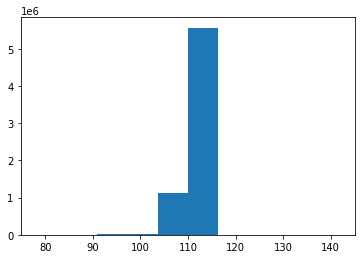

In [13]:
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [14]:
print('number of unique sequences in the first {} positions: {}'.format(ARGS['head_len'], len(df['dna'].str[:ARGS['head_len']].unique())))

number of unique sequences in the first 17 positions: 1


In [15]:
print('number of unique sequences in the last {} positions: {}'.format(ARGS['tail_len'], len(df['dna'].str[-ARGS['tail_len']:].unique())))

number of unique sequences in the last 13 positions: 1


In [16]:
print(df.head())

                                                       dna  expression  len
3963995  TGCATTTTTTTCACATCCTATTACACAAAGGGAGTTTAGTTGTGTA...        11.0  110
3014003  TGCATTTTTTTCACATCGTGGGTTTCGAAACAACGGTCTAACGAAC...        12.0  110
1062388  TGCATTTTTTTCACATCAATGGGACTGGTACTTTACTTTTGCTTAC...         8.0  110
5110238  TGCATTTTTTTCACATCTTCGGCCCCGGCTAAGTAGCGATAGAGCT...        11.0  110
1781111  TGCATTTTTTTCACATCGTAGCCCAGCCATGAGAACGTGGGACGTA...        11.0  110


In [17]:
# 앞 뒤 자르는 코드
df['dna'] = df['dna'].str[ARGS['head_len']:]
df['dna'] = df['dna'].str[:-ARGS['tail_len']]

min len: 48
max len: 112


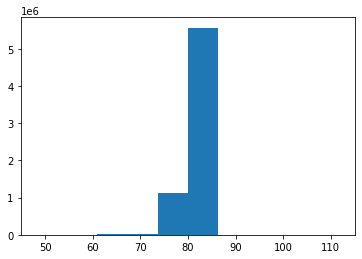

In [18]:
df['len'] = df['dna'].str.len()
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [19]:
print(df.head())

                                                       dna  expression  len
3963995  CTATTACACAAAGGGAGTTTAGTTGTGTAATTGCGTGGTTGCAATA...        11.0   80
3014003  GTGGGTTTCGAAACAACGGTCTAACGAACAGTACTATTGATGCCTG...        12.0   80
1062388  AATGGGACTGGTACTTTACTTTTGCTTACCCCTGCACGTTACAACA...         8.0   80
5110238  TTCGGCCCCGGCTAAGTAGCGATAGAGCTGCGATGGTTGGGGGGAC...        11.0   80
1781111  GTAGCCCAGCCATGAGAACGTGGGACGTATGCACTAATGATAAAAG...        11.0   80


In [20]:
print('removing {} samples which length is greater than {}'.format(len(df[df['len'] > ARGS['max_width']]), ARGS['max_width']))

removing 1690 samples which length is greater than 100


In [21]:
df = df[df['len'] <= ARGS['max_width']]

In [22]:
print('dataset size: %d' % (len(df)))

dataset size: 6737568


In [23]:
df['dna'] = df['dna'].str.pad(width = ARGS['max_width'], side = 'both', fillchar = 'N')
df['dna'] = df['dna'] + df['dna'].apply(lambda x: str(Seq(x).reverse_complement())).astype('string')

In [24]:
n_positions = int(ARGS['max_width'] * 2)
print('# positions=%d' % (n_positions))

# positions=200


In [25]:
#dna = df['dna'].apply(list) # this will eat up all memory even on the high mem instance
dna = np.empty((0, n_positions), np.uint8)
for x in np.array_split(df['dna'], 10): # split data into chunks
  y = np.array(x.apply(list))
  y = np.vstack(y)
  y = np.vectorize(ARGS['alphabets'].get)(y)
  y = y.astype(np.uint8)
  print(y.shape)
  dna = np.append(dna, y, axis = 0)

(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673757, 200)
(673756, 200)
(673756, 200)


In [26]:
input_dim = int(5) # A,C,G,T,N

In [27]:
expression = df['expression'].to_numpy()
print(expression[:5])
expression_std = np.std(expression)
expression_mean = np.mean(expression)
expression = (expression - expression_mean) / expression_std
print(expression[:5])
#expression = tf.cast(expression, tf.float32)

[11. 12.  8. 11. 11.]
[-0.06199268  0.35981932 -1.32742868 -0.06199268 -0.06199268]


In [28]:
expression.shape

(6737568,)

In [29]:
base = np.zeros(dna.shape, dtype = np.uint8)
base[dna == 4] = 0 #
base[(dna == 0) | (dna == 2)] = 1 # A/G
base[(dna == 1) | (dna == 3)] = 2 # C/T

In [30]:
ds = {    'seq' : dna,
    'expression' : expression,
    'base' : base,
}

In [31]:
#ds = tf.data.Dataset.from_tensor_slices({
#    'seq' : dna,
#    'expression' : expression,
#    'base' : base,
#})

In [32]:
#print('writing data to {}'.format(ARGS['local_data_dir']))
#tf.data.experimental.save(ds, ARGS['local_data_dir'])

In [35]:
ARGS['model_id'] = 'm20230302_ti'
ARGS['local_data_dir'] = '/Data1/PGE/torch_ti/data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [37]:
import os

#os.makedirs(ARGS['local_data_dir'])

with open(ARGS['local_data_dir']+"data.pk","wb") as f:
    pk.dump(ds, f)

In [ ]:
with open(ARGS['local_data_dir']+"data.pk","rb") as fr:
    da = pk.load(fr)

In [ ]:
print(da.keys())
print(da['seq'].shape)
print(da['expression'].shape)

dict_keys(['seq', 'expression', 'base'])
(6737568, 200)
(6737568,)


Note that to load a previously saved dataset, you need to specify element_spec -- a type signature of the elements of the saved dataset, which can be obtained via tf.data.Dataset.element_spec. This requirement exists so that shape inference of the loaded dataset does not need to perform I/O.

In [ ]:
#ds.element_spec

{'seq': TensorSpec(shape=(200,), dtype=tf.uint8, name=None),
 'expression': TensorSpec(shape=(), dtype=tf.float32, name=None),
 'base': TensorSpec(shape=(200,), dtype=tf.uint8, name=None)}

# SessionInfo

In [63]:
session_info.show()